<a href="https://colab.research.google.com/github/adityachoudharyclg/internshipProjectClg/blob/master/Dolphin_autoencoder_Adarsh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import networkx.generators as gen
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
import networkx as nx
from sklearn.cluster import KMeans
from sklearn import metrics
from networkx.algorithms.community import greedy_modularity_communities
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [ ]:
!wget https://github.com/adityachoudharyclg/internshipProjectClg/archive/master.zip
!unzip master.zip

--2020-07-09 15:05:08--  https://github.com/adityachoudharyclg/internshipProjectClg/archive/master.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/adityachoudharyclg/internshipProjectClg/zip/master [following]
--2020-07-09 15:05:09--  https://codeload.github.com/adityachoudharyclg/internshipProjectClg/zip/master
Resolving codeload.github.com (codeload.github.com)... 140.82.114.9
Connecting to codeload.github.com (codeload.github.com)|140.82.114.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [   <=>              ] 255.25K   359KB/s    in 0.7s    

2020-07-09 15:05:11 (359 KB/s) - ‘master.zip’ saved [261373]

Archive:  master.zip
a781980be3b501c0587508cb32e0ae6f289357e0
   creating: internshipProjectClg-master/
  inflati

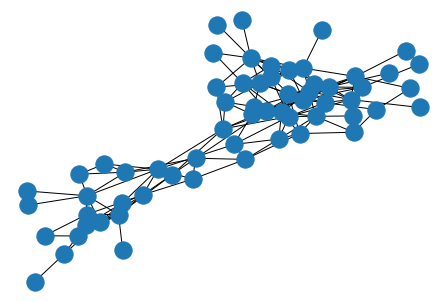

In [ ]:
# Load the dataset and return modularity matrix and truth values
def load_dataset(name):
  filename = 'internshipProjectClg-master/dolphins_gt.gml'
  G_data = nx.read_gml(filename)
  if(name=='polblogs'):
    G_data = G_data.to_undirected()
    G_data = nx.Graph(G_data)
  B_data = nx.modularity_matrix(G_data)
  # Karate
  if(name=='karate'):
    G_data=nx.karate_club_graph()
    B_data=nx.modularity_matrix(G_data)
  
  nx.draw(G_data)
  plt.show()
  return G_data, B_data
G_data,B_data=load_dataset('football')
# print(greedy_modularity_communities(G_data))

In [ ]:
# Train test split here batch size=train_ds
def givetrain(inputs,targets):  
  train_ds = TensorDataset(inputs, targets)
  train_dl=DataLoader(train_ds,batch_size=len(train_ds))
  return train_dl

In [ ]:
# Test The data
print(B_data.shape,len(G_data.edges()))

(62, 62) 159


In [ ]:
class AE(nn.Module):
    def __init__(self,in_layers,hidden_layers):
        super().__init__()
        # Encoder
        self.encoder_hidden_layer = nn.Linear(
            in_features=in_layers, out_features=hidden_layers
        )
        self.encoder_output_layer = nn.Linear(
            in_features=hidden_layers, out_features=hidden_layers
        )
        # DEcoder
        self.decoder_hidden_layer= nn.Linear(
            in_features=hidden_layers, out_features=hidden_layers
        )
        self.decoder_output_layer = nn.Linear(
            in_features=hidden_layers, out_features=in_layers
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.tanh(activation)
        # activation = nn.Dropout(p=0.01)(activation)
        code = self.encoder_output_layer(activation)
        code = torch.tanh(code)
        # code = nn.Dropout(p=0.01)(code)
        encoder=code
        activation = self.decoder_hidden_layer(code)
        activation = torch.tanh(activation)
        # activation = nn.Dropout(p=0.01)(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.tanh(activation)
        # reconstructed = nn.Dropout(p=0.01)(reconstructed)
        return encoder,reconstructed

In [ ]:
epochs = 1000
learning_rate = 1e-3

In [ ]:
#  use gpu if available
device = torch.device("cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model1 = AE(hidden_layers=32,in_layers=62).to(device)
model2=AE(hidden_layers=16,in_layers=32).to(device)
model3=AE(hidden_layers=8,in_layers=16).to(device)
# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer1 = optim.Adam(model1.parameters(), lr=learning_rate)
optimizer2 = optim.Adam(model2.parameters(), lr=learning_rate)
optimizer3 = optim.Adam(model3.parameters(), lr=learning_rate)

# mean-squared error loss
def loss_func(input,target):
  return F.mse_loss(input,target)
print(model2)

AE(
  (encoder_hidden_layer): Linear(in_features=32, out_features=16, bias=True)
  (encoder_output_layer): Linear(in_features=16, out_features=16, bias=True)
  (decoder_hidden_layer): Linear(in_features=16, out_features=16, bias=True)
  (decoder_output_layer): Linear(in_features=16, out_features=32, bias=True)
)


In [ ]:
def train_model(epochs,train_dl,model,optimizer,fl=0):
  enc,out=0,0
  hist=[]
  for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_dl:
      # reset the gradients back to zero
      # PyTorch accumulates gradients on subsequent backward passes
        # optimizer.zero_grad()
        optimizer.zero_grad()
        # compute reconstructions
        encoder,outputs = model(batch_features.float())
        # out=outputs
        if(fl==1):
          outputs=outputs.double()
        # compute training reconstruction loss
        train_loss = loss_func(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        enc=encoder
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
        
        # enc=encoder  
    # compute the epoch training loss
    loss = loss / len(train_dl)
    hist.append(loss)
    
    # display the epoch training loss
    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))
  return(enc,hist)

In [ ]:
B_data=np.asarray(B_data,dtype=np.float64)
inputs=torch.from_numpy(B_data)
targets=torch.from_numpy(B_data)

train_dl=givetrain(inputs,targets)

# AE 1 training
encoder,hist=train_model(200,train_dl,model1,optimizer1,fl=1)
train_dl=givetrain(encoder.detach(),encoder.detach())
print(encoder.detach().shape)

# AE 2 training
encoder,hist=train_model(200,train_dl,model2,optimizer2)
train_dl=givetrain(encoder.detach(),encoder.detach())
print(encoder.detach().shape)

# AE 3 training
# encoder,hist=train_model(200,train_dl,model3,optimizer3)
# train_dl=givetrain(encoder.detach(),encoder.detach())
# print(encoder)
# print(encoder.detach().shape)

epoch : 1/200, recon loss = 0.08625777
epoch : 2/200, recon loss = 0.08462256
epoch : 3/200, recon loss = 0.08309427
epoch : 4/200, recon loss = 0.08166573
epoch : 5/200, recon loss = 0.08032964
epoch : 6/200, recon loss = 0.07907848
epoch : 7/200, recon loss = 0.07790481
epoch : 8/200, recon loss = 0.07680146
epoch : 9/200, recon loss = 0.07576164
epoch : 10/200, recon loss = 0.07477885
epoch : 11/200, recon loss = 0.07384696
epoch : 12/200, recon loss = 0.07296016
epoch : 13/200, recon loss = 0.07211308
epoch : 14/200, recon loss = 0.07130080
epoch : 15/200, recon loss = 0.07051883
epoch : 16/200, recon loss = 0.06976311
epoch : 17/200, recon loss = 0.06902997
epoch : 18/200, recon loss = 0.06831612
epoch : 19/200, recon loss = 0.06761860
epoch : 20/200, recon loss = 0.06693474
epoch : 21/200, recon loss = 0.06626222
epoch : 22/200, recon loss = 0.06559898
epoch : 23/200, recon loss = 0.06494331
epoch : 24/200, recon loss = 0.06429377
epoch : 25/200, recon loss = 0.06364929
epoch : 2

In [ ]:
B_data_X=encoder.detach().numpy()

In [ ]:
kmeans = KMeans(n_clusters=4,init='k-means++')
kmeans.fit(B_data_X)
X_ae = kmeans.labels_
#---------------------------------------------------------|Ground Truth|-------
c_attributes = nx.get_node_attributes(G_data,'value')
c_groups = []

for i, val in enumerate(c_attributes.values()):
    c_groups.append(val)
# c_groups=[0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1]        
X_gt = np.array(c_groups)
print(X_ae)
print(X_gt)
# print(G_data.nodes)
metrics.normalized_mutual_info_score(X_gt, X_ae, average_method='arithmetic')

[2 0 2 1 1 3 3 0 1 3 2 1 2 3 2 1 2 3 1 0 2 1 2 1 1 0 0 0 0 1 2 2 3 2 2 1 0
 2 2 2 2 3 2 2 2 1 2 2 2 2 2 1 2 2 3 1 2 3 2 1 2 2]
[1 0 1 2 3 0 0 0 2 0 1 3 2 0 2 3 2 0 3 0 2 3 0 3 3 0 0 0 1 3 1 0 0 2 2 3 2
 2 2 2 2 0 1 2 2 3 2 1 0 2 2 3 2 2 0 3 0 0 2 2 0 2]


0.5053385404063434

In [ ]:
max=0
index_max=0
for value in range(0,1000):
    kmeans = KMeans(n_clusters=12,random_state=value,init='k-means++')
    kmeans.fit(B_data_X)
    X_ae = kmeans.labels_
    #---------------------------------------------------------|Ground Truth|-------
    c_attributes = nx.get_node_attributes(G_data,'value')
    c_groups = []

    for i, val in enumerate(c_attributes.values()):
        c_groups.append(val)
    # Remove this in Other datasets
    # c_groups=[0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1]        
   
    X_gt = np.array(c_groups)
    # print(X_ae)
    # print(X_gt)
    temp=metrics.normalized_mutual_info_score(X_gt, X_ae, average_method='arithmetic')
    if(temp>max):
        max=temp
        index_max=value
    print(max)
print(index_max,max)

0.48610074781057877
0.48610074781057877
0.4984293137797979
0.4984293137797979
0.4984293137797979
0.5164724242216717
0.5164724242216717
0.5164724242216717
0.5164724242216717
0.5164724242216717
0.5164724242216717
0.5164724242216717
0.5164724242216717
0.5164724242216717
0.5164724242216717
0.5164724242216717
0.5164724242216717
0.5164724242216717
0.5164724242216717
0.5164724242216717
0.5164724242216717
0.5164724242216717
0.5164724242216717
0.5164724242216717
0.5164724242216717
0.5164724242216717
0.5164724242216717
0.5164724242216717
0.5164724242216717
0.5164724242216717
0.5164724242216717
0.5412454683328235
0.5412454683328235
0.5412454683328235
0.5412454683328235
0.5412454683328235
0.5412454683328235
0.5412454683328235
0.5412454683328235
0.5412454683328235
0.5412454683328235
0.5412454683328235
0.5412454683328235
0.5559363671947445
0.5559363671947445
0.5559363671947445
0.5559363671947445
0.5559363671947445
0.5559363671947445
0.5559363671947445
0.5559363671947445
0.5559363671947445
0.55593636